In [45]:
import pandas as pd
import numpy as np
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp



#Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import BaselineOnly
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle



In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
movies= pd.read_csv('movies.csv')

In [4]:
train.head(10)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837
5,120949,81768,3.0,1289595242
6,19630,62049,4.0,1246729817
7,21066,2282,1.0,945785907
8,117563,120474,4.0,1515108225
9,144018,1997,5.0,1109967647


In [26]:
train.drop(['timestamp'], axis=1, inplace=True)
train.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [46]:
train_movies=pd.merge(train,movies)

# EDA

In [47]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


# Distribution of Most common Genres.

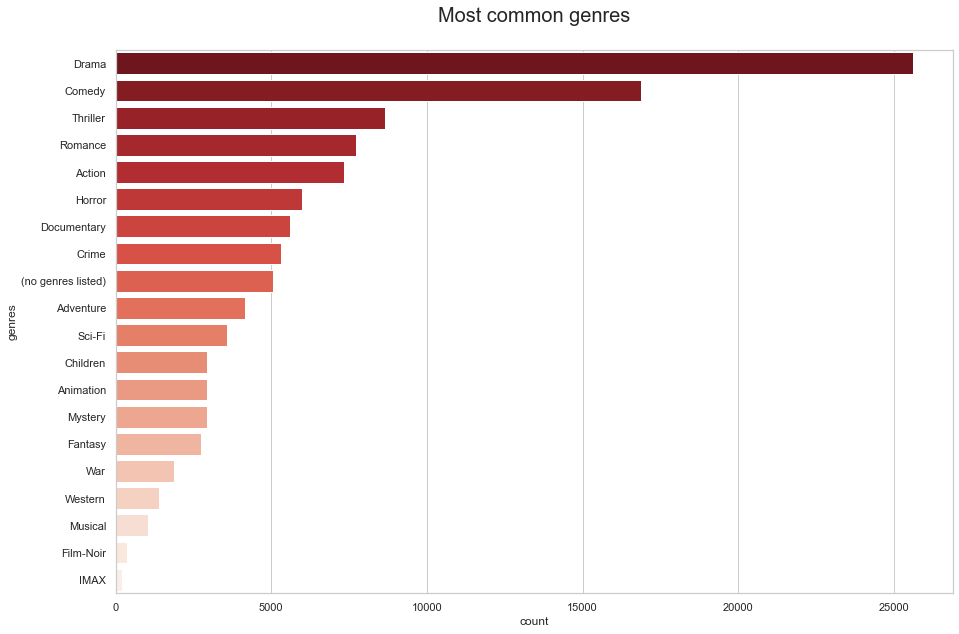

In [48]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

We can see that drama has the highest count meaning it is the most common genre in the data set, followed by comedy,Thriller and Romance.This make sense since most paraents prefer to watch drama movies with their kids.

# Distribution of Movies Ratings.

In [27]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = train['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / train.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie-ratings'.format(train.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

We can see that over 26% of all ratings in the data are 4, and very few ratings are 3 or 5. High rating movies mean they are generallt really good movies and low rating movies mean they are generally reall bad movies.

# Distribution of Ratings per Movie.

In [28]:
# Number of ratings per movie
data = train.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [32]:
# Group the number of ratings per movie in ascending order(from the highest-lower ratings)
train.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,movieId,rating
314,318,32831
351,356,32383
292,296,31697
585,593,29444
2479,2571,29014
257,260,27560
475,480,25518
522,527,24004
108,110,23722
2866,2959,23536


Most of the movies in the data received less than 5 ratings, and very few movies have many ratings, although the most rated movie has received 32,831 ratings.

# Distribution of ratings per user.

In [34]:
# Number of ratings per user
data = train.groupby('userId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [35]:
train.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
109730,109731,2671
49402,49403,2670
92045,92046,2579
110970,110971,2288
30878,30879,2284


Most of the users in the data gave less than 5 ratings, and not many users gave many ratings, although the most productive user have given 13,952 ratings.
I’m sure you have noticed that the above two plots share the same distribution. The number of ratings per movie and the number of ratings per user decay exponentially.

To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated movies and rarely rating users.

In [36]:
min_movie_ratings = 50
filter_movies = train['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 50
filter_users = train['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

train_new = train[(train['movieId'].isin(filter_movies)) & (train['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(train.shape))
print('The new data frame shape:\t{}'.format(train_new.shape))

The original data frame shape:	(10000038, 3)
The new data frame shape:	(7382932, 3)


Wow! we now have a new dataframe of 7382932 entries after removing less rated movies and users.

# Building Models (  Basic Algarithms )

# SURPRISE LIBRARY.

To load a data set from the above pandas data frame, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.


In [39]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(train_new[['userId', 'movieId', 'rating']], reader)

With the Surprise library, we will benchmark the following algorithms:

# Basic algorithms

# NormalPredictor

NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

# BaselineOnly

BaselineOnly algorithm predicts the baseline estimate for given user and item.

# k-NN algorithms

# KNNBasic

KNNBasic is a basic collaborative filtering algorithm.

# KNNWithMeans

KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

# KNNWithZScore

KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

# KNNBaseline

KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating

# Matrix Factorization-based algorithms

# SVD

SVD algorithm is equivalent to Probabilistic Matrix Factorization

# SVDpp

The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.

# NMF

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

# Slope One

SlopeOne is a straightforward implementation of the SlopeOne algorithm.

# Co-clustering

Coclustering is a collaborative filtering algorithm based on co-clustering.

# We use “rmse” as our accuracy metric for the predictions.

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [ ]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(train_new[['userId', 'movieId', 'rating']], reader)

In [ ]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

In [ ]:
# BselineOnly model
algo_b= BaselineOnly()
trainset,testset= train_test_split(data, test_size=0.1)
#train and test algorithm.
algo_b.fit(trainset)
predictions_b=algo_b.test(testset)
# compute and print Root mean aquared error
print(accuracy.rmse(predictions_b, verbose=True)) 

In [5]:
test.head(10)

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318
5,1,8405
6,1,8786
7,2,150
8,2,356
9,2,497


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
train.shape

(10000038, 4)

In [8]:
test.shape

(5000019, 2)

In [10]:
movies.shape

(62423, 3)

In [11]:
movies.movieId.nunique()

62423

In [12]:
movies.isnull().sum

<bound method DataFrame.sum of        movieId  title  genres
0        False  False   False
1        False  False   False
2        False  False   False
3        False  False   False
4        False  False   False
...        ...    ...     ...
62418    False  False   False
62419    False  False   False
62420    False  False   False
62421    False  False   False
62422    False  False   False

[62423 rows x 3 columns]>

In [13]:
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [14]:
train_movies=pd.merge(train,movies)

In [15]:
train_movies.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [16]:
train_movies.shape

(10000038, 6)

In [17]:
train_movies.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

In [18]:
train_movies.isnull().values.any()

False

In [19]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [25]:
train_movies.groupby('genres').genres.count().sort_values(ascending=False)

genres
Drama                                             706335
Comedy                                            606057
Comedy|Romance                                    360826
Drama|Romance                                     318408
Comedy|Drama                                      288847
                                                   ...  
Adventure|Crime|Drama|Fantasy|Mystery|Thriller         1
Action|Horror|Sci-Fi|War|Western                       1
Children|Documentary|Drama|Romance                     1
Action|Horror|Thriller|War                             1
Action|Adventure|Mystery                               1
Name: genres, Length: 1558, dtype: int64

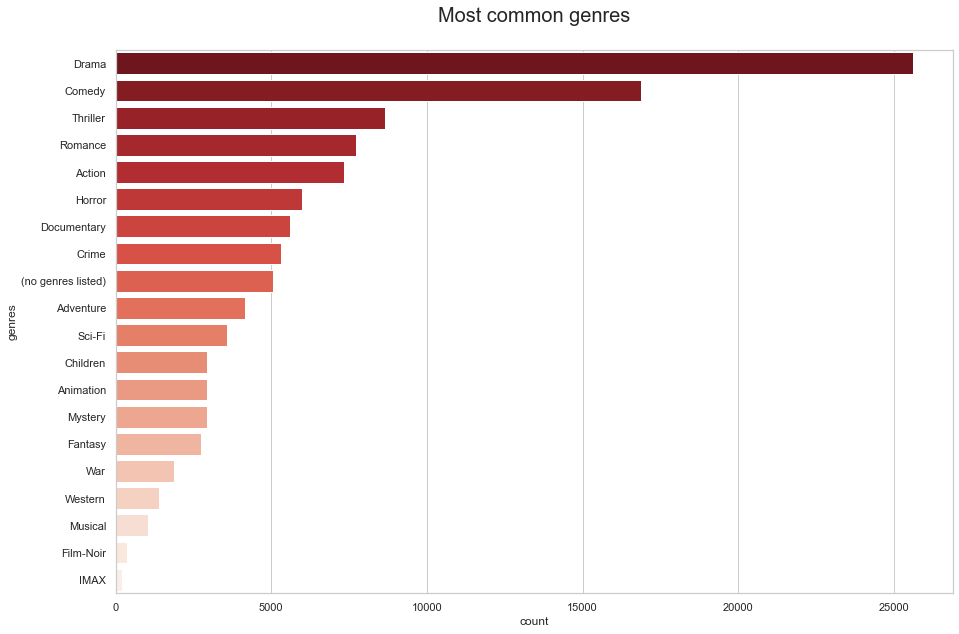

In [20]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

In [21]:
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


Text(0, 0.5, 'Feature 2')

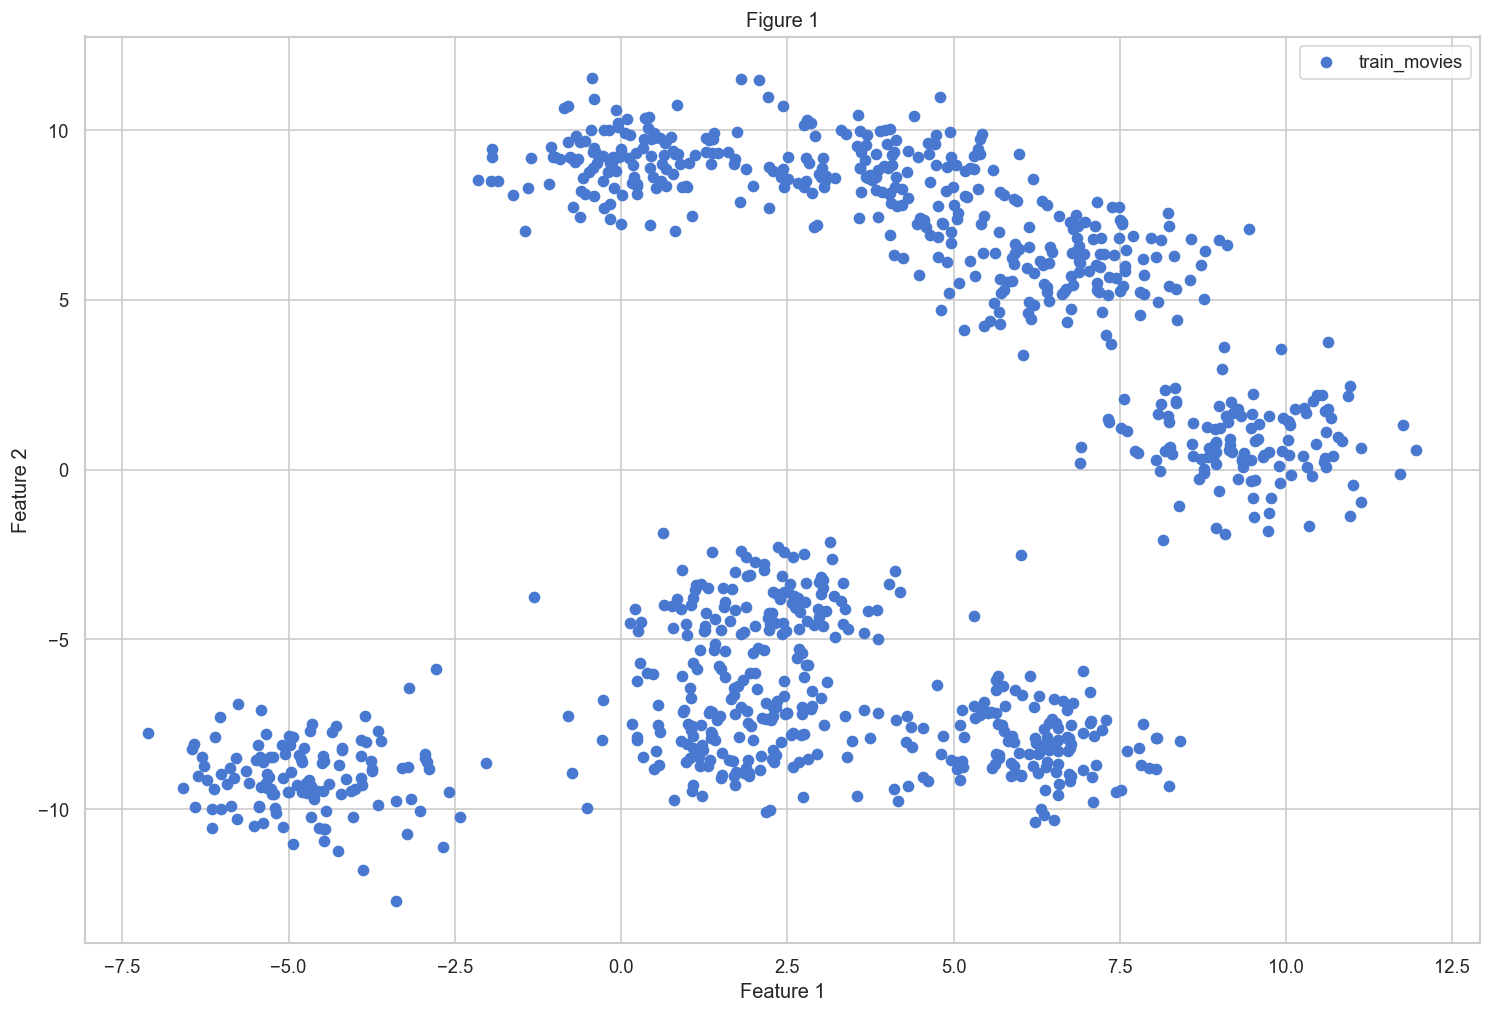

In [23]:
# make 8 blobs in 2D space
n_features = 2
centers = 8

X, y = make_blobs(n_samples=1000, centers=centers, n_features=n_features, random_state=68) #rand = 8, 42

df = pd.DataFrame(X, columns=[*[f'feature_{i}' for i in range(n_features)]])

# plot data
plt.figure(dpi=120)
x1 = df['feature_0']
x2 = df['feature_1']
plt.scatter(x1, x2, label="train_movies")

plt.legend()
plt.title("Figure 1")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')